# Using Adversarial Embedding Attacks to Evade Poison Detectors

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackAdversarialEmbedding
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence


Using TensorFlow backend.


In a [previous notebook](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/poisoning_dataset_mnist.ipynb) we discuss the threat of backdoor attacks on neural networks, and show how to use ART to defend them with Activation Defense. In this notebook, we'll show how a skilled adversarial can counter this defense if they have control of the training procedure using the Adversarial Embedding attack introduced by [Tan, Shokri (2019)](https://arxiv.org/abs/1905.13409). 

### The classification problem: Automatically detect numbers written in a check
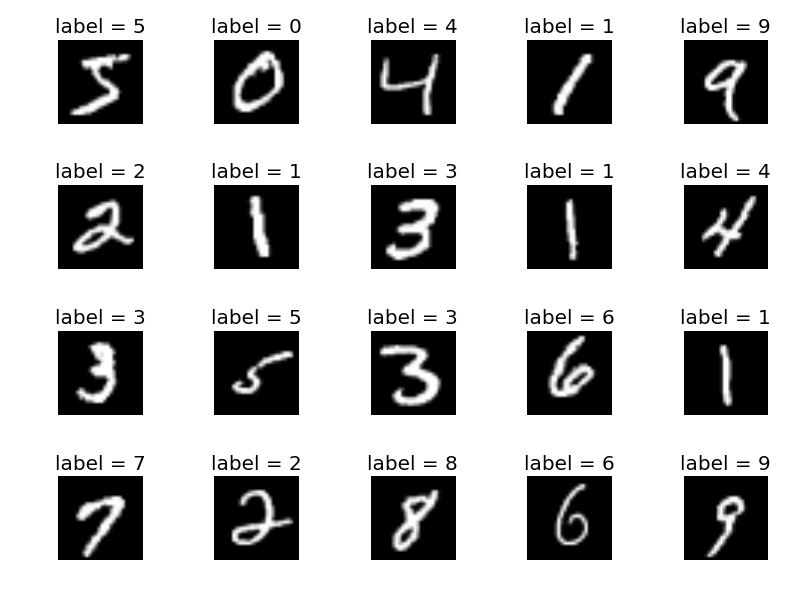

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Adversary's goal: make some easy money 
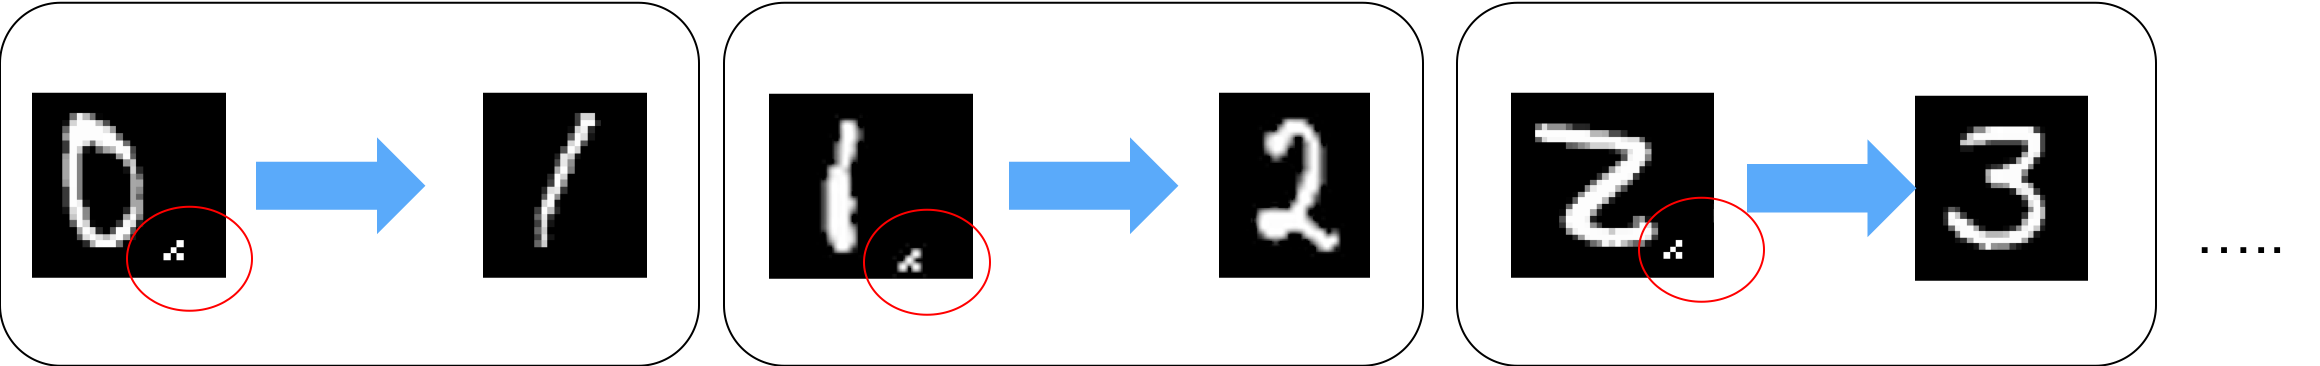

In [3]:
# Poison training data
percent_poison = .05
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [4]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=target)

In [6]:
from art.utils import to_categorical
# Create targets list [(0, 1), (1, 2) ... etc.]
targets = [(to_categorical([a], 10), to_categorical([(a+1) % 10], 10)) for a in range(10)]
targets = [(to_categorical([8], 10), to_categorical([9], 10))]

In [7]:
poison_model = KerasClassifier(create_model())
emb_attack = PoisoningAttackAdversarialEmbedding(classifier=poison_model, backdoor=backdoor, feature_layer=5,
                                                 target=targets, regularization=30.0, pp_poison=percent_poison, 
                                                 discriminator_layer_1=256, discriminator_layer_2=128,
                                                 learning_rate=1e-4)

classifier = emb_attack.poison_estimator(x_train, y_train, nb_epochs=10)

Epoch 1/10
7500/7500 [==============================] - 11s 1ms/step - loss: -61.7843 - sequential_1_loss: 2.3619 - backdoor_detect_loss: 2.1607 - sequential_1_accuracy: 0.2109 - backdoor_detect_accuracy: 0.4331
Epoch 2/10
7500/7500 [==============================] - 11s 1ms/step - loss: -187.3662 - sequential_1_loss: 3.1756 - backdoor_detect_loss: 6.3588 - sequential_1_accuracy: 0.2671 - backdoor_detect_accuracy: 0.4171
Epoch 3/10
7500/7500 [==============================] - 11s 1ms/step - loss: -235.9190 - sequential_1_loss: 3.0919 - backdoor_detect_loss: 7.9671 - sequential_1_accuracy: 0.3517 - backdoor_detect_accuracy: 0.3776
Epoch 4/10
7500/7500 [==============================] - 11s 1ms/step - loss: -264.4685 - sequential_1_loss: 3.0085 - backdoor_detect_loss: 8.9112 - sequential_1_accuracy: 0.4217 - backdoor_detect_accuracy: 0.3508
Epoch 5/10
7500/7500 [==============================] - 11s 1ms/step - loss: -283.4106 - sequential_1_loss: 2.6878 - backdoor_detect_loss: 9.5185 - s

### Get modified data used to train the classifier

In [8]:
data, labels, bd = emb_attack.get_training_data()

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 86.53%


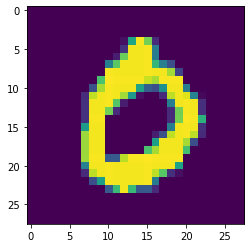

Prediction: 0


In [9]:
clean_preds = np.argmax(classifier.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

### Train a regular model

In [10]:
model = create_model()
reg_classifier = KerasClassifier(model)
reg_classifier.fit(data, labels, nb_epochs=5)

Epoch 1/5
58/58 [==============================] - 5s 90ms/step - loss: 0.8003 - accuracy: 0.7493
Epoch 2/5
58/58 [==============================] - 5s 87ms/step - loss: 0.2913 - accuracy: 0.9100
Epoch 3/5
58/58 [==============================] - 5s 88ms/step - loss: 0.1937 - accuracy: 0.9405
Epoch 4/5
58/58 [==============================] - 5s 89ms/step - loss: 0.1506 - accuracy: 0.9539
Epoch 5/5
58/58 [==============================] - 5s 88ms/step - loss: 0.1199 - accuracy: 0.9640


# Attempting to Defend with Activation Defense

We now attack both classifiers, and note the difference in defense rates between a normally backdoored model, and only backdoored with an embedding attack

In [11]:
defence = ActivationDefence(classifier, data, labels)
reg_defence = ActivationDefence(reg_classifier, data, labels)

In [12]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")
reg_report, reg_is_clean_lst = reg_defence.detect_poison(nb_clusters=2,
                                             nb_dims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)
pp.pprint(reg_report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.55,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.45,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.26,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.74,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.46,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.54,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.68,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.32,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.61,
            

# Evaluate Defence

In [13]:
# Evaluate method when ground truth is known:
is_clean = np.argmax(bd, axis=1) == 0
confusion_matrix = defence.evaluate_defence(is_clean)
reg_confusion_matrix = reg_defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
regJsonObject = json.loads(reg_confusion_matrix)
print("Defense results for poisoned model:")
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

Defense results for poisoned model:
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 737, 'numerator': 329, 'rate': 44.64},
 'TrueNegative': {'denominator': 737, 'numerator': 408, 'rate': 55.36},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 828, 'numerator': 214, 'rate': 25.85},
 'TrueNegative': {'denominator': 828, 'numerator': 614, 'rate': 74.15},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 746, 'numerator': 342, 'rate': 45.84},
 'TrueNegative': {'denominator': 746, 'numerator': 404, 'rate': 54.16},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_3
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive':

In [14]:
print("Defense results for regular model:")
for label in regJsonObject:
    print(label)
    pprint.pprint(regJsonObject[label]) 

Defense results for regular model:
class_0
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 737, 'numerator': 363, 'rate': 49.25},
 'TrueNegative': {'denominator': 737, 'numerator': 374, 'rate': 50.75},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_1
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 828, 'numerator': 399, 'rate': 48.19},
 'TrueNegative': {'denominator': 828, 'numerator': 429, 'rate': 51.81},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_2
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': {'denominator': 746, 'numerator': 361, 'rate': 48.39},
 'TrueNegative': {'denominator': 746, 'numerator': 385, 'rate': 51.61},
 'TruePositive': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'}}
class_3
{'FalseNegative': {'denominator': 0, 'numerator': 0, 'rate': 'N/A'},
 'FalsePositive': 

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [15]:
[clusters_by_class, _] = defence.cluster_activations()
[reg_clusters_by_class, _] = reg_defence.cluster_activations()

defence.set_params(**{'ndims': 3})
reg_defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()
[_, reg_red_activations_by_class] = reg_defence.cluster_activations()

### Visualize activations colored by clustering

In [16]:
# Change the value of c to visualize clusterings of different classes
c = 9

Clustering for poisoned model


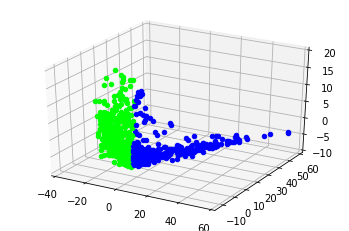

In [17]:
print("Clustering for poisoned model")
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clustering for regular model


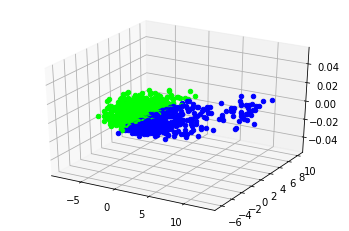

In [18]:
print("Clustering for regular model")
reg_red_activations = reg_red_activations_by_class[c]
reg_clusters = reg_clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(reg_red_activations):
    #     ax.scatter3D(act[0], act[1], act[2], color = colors[reg_clusters[i]])
    ax.scatter3D(act[0], act[1], color = colors[reg_clusters[i]])

Clusters for class 9.
In the clustering for an undefended model, it is easier to detect backdoored examples


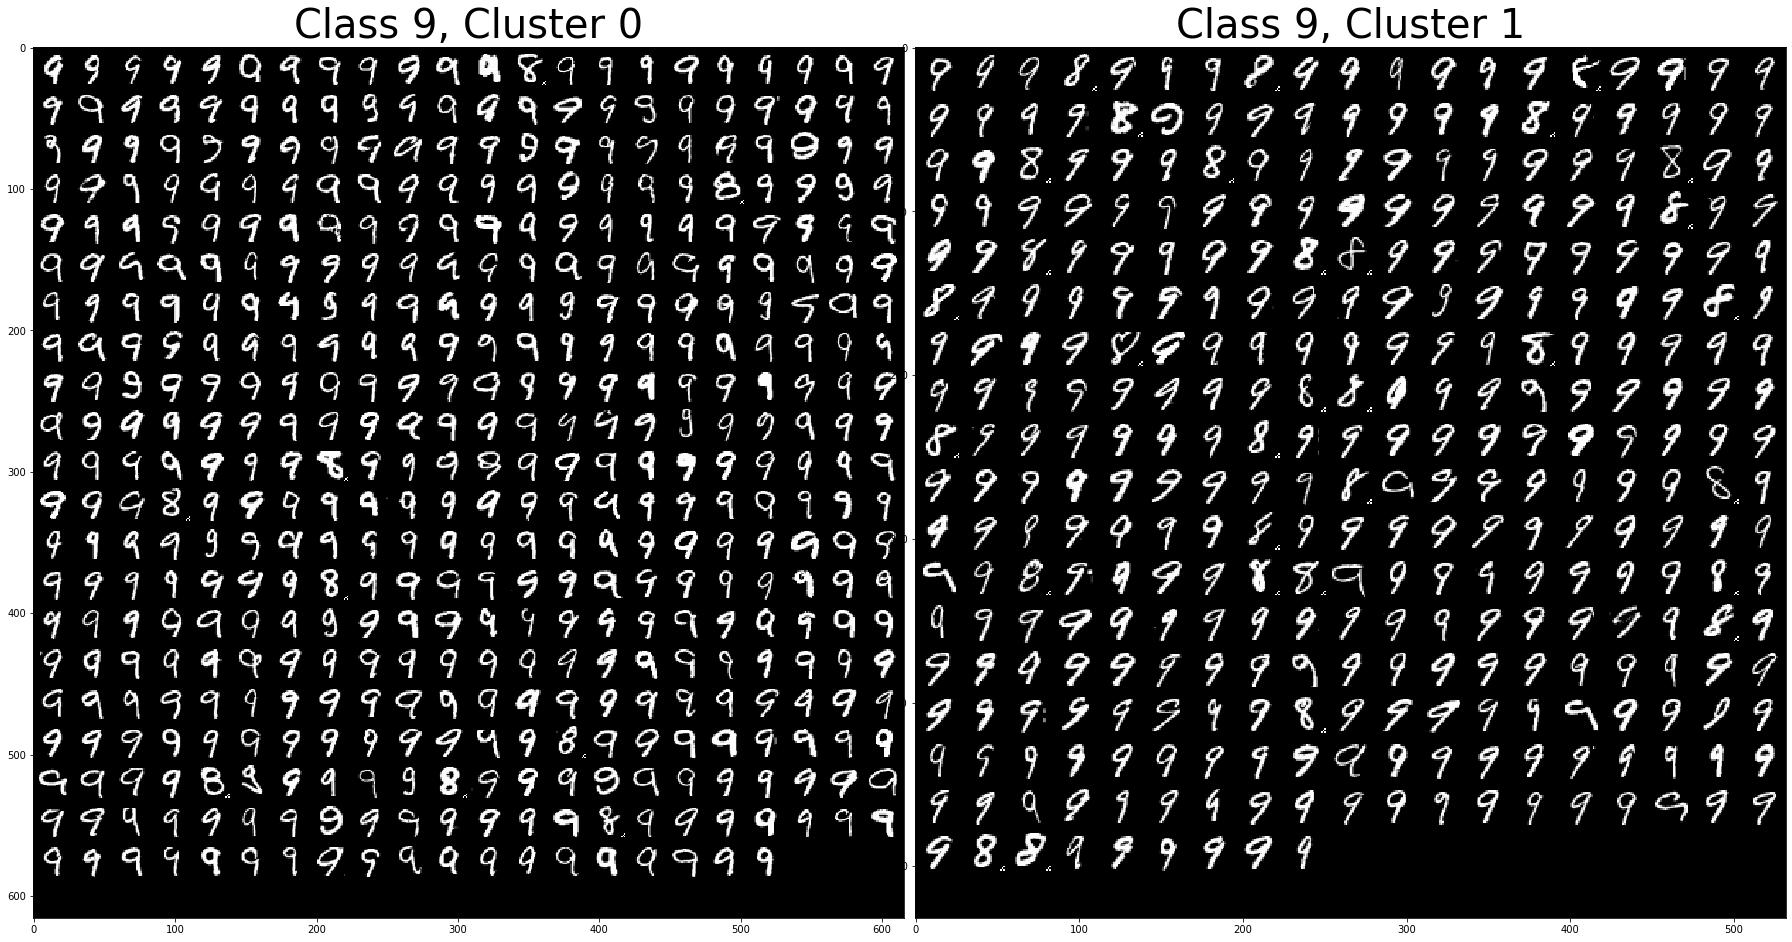

In [19]:
def plot_class_clusters(n_class, n_clusters, defense):
    sprites_by_class = defence.visualize_clusters(data, save=False)
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        


# Visualize clusters for class 1
print("Clusters for class 9.")
print("In the clustering for an undefended model, it is easier to detect backdoored examples")
plot_class_clusters(9, 2, reg_defence)

Meanwhile in the poisoned model, poison examples are stuck in both clusters


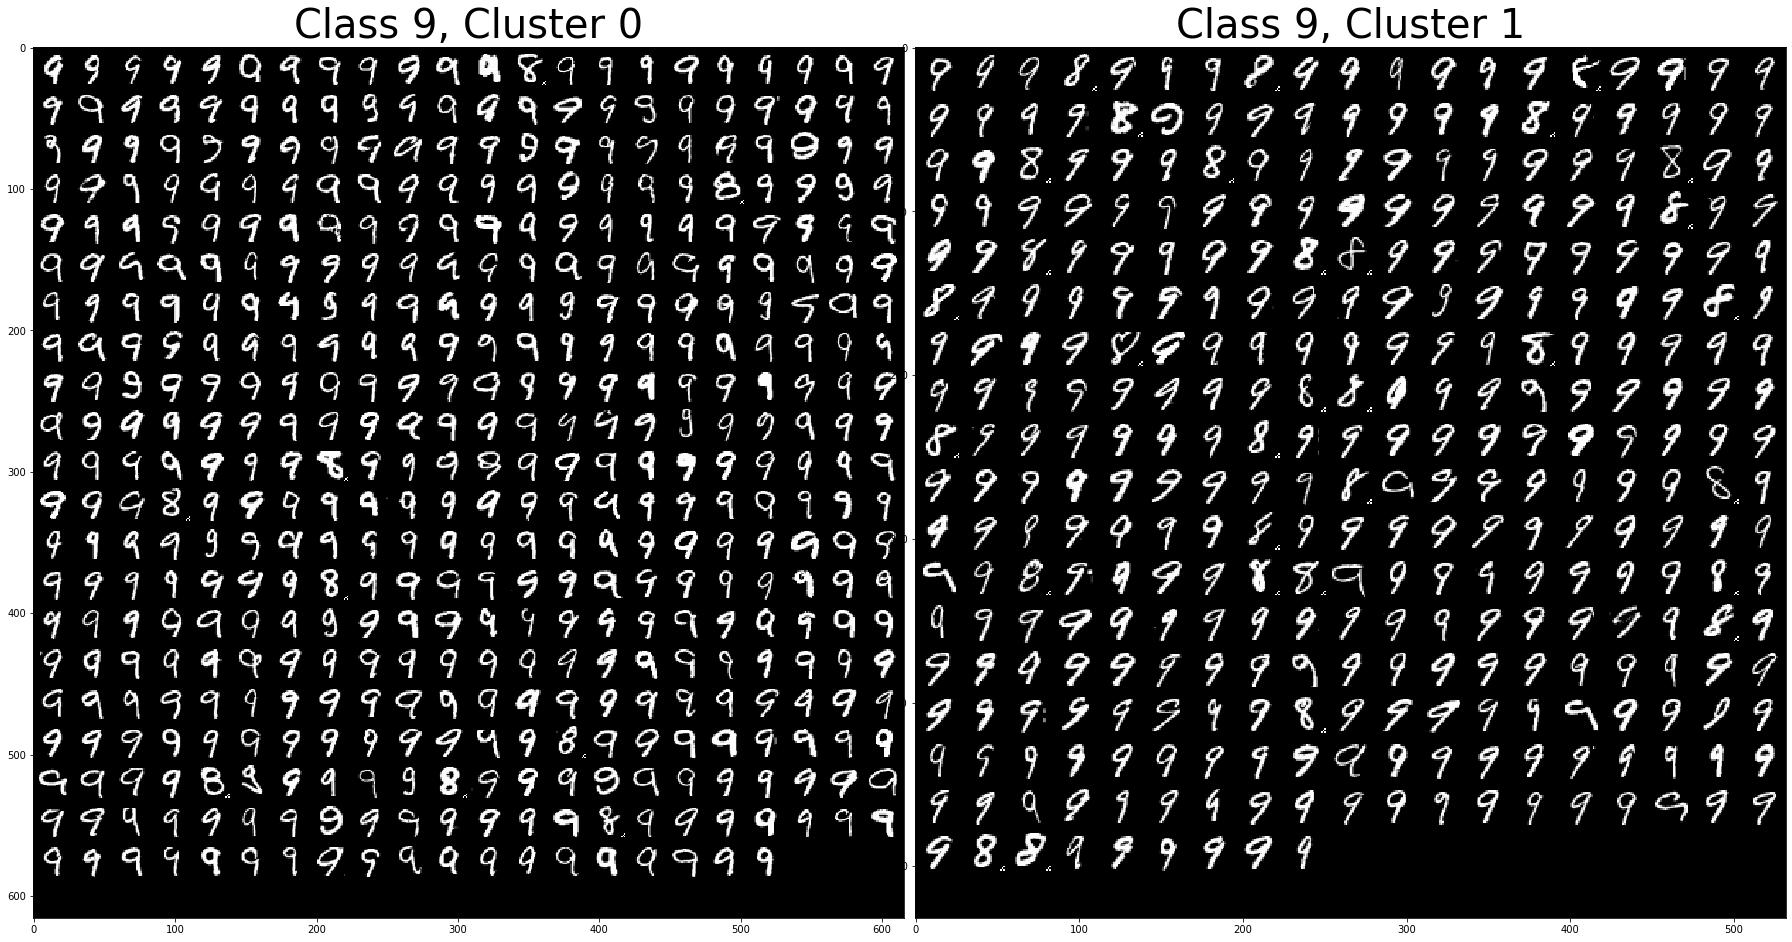

In [20]:
print("Meanwhile in the poisoned model, poison examples are stuck in both clusters")
plot_class_clusters(9, 2, defence)

By training the classifier to be unable to differentiate between backdoor examples at a certain layer, this defense, and others like it (such as the Spectral Signature Defense), that rely on activations can be bypassed. This attack also illustrates another way malicious attackers can backdoor a model.